# 102 category flower classification using ResNet50

## 1. Import Necessary Libraries

In [1]:
import os
from pathlib import Path
import scipy

## 2. Define Data Paths
We set paths to the data directory and metadata files (label and split files).

In [2]:
# Set path to data directory
data_dir = Path("data")

# Set path to label files & split files
label_file = data_dir / "imagelabels.mat"
split_file = data_dir / "setid.mat" 

## 3. Load Dataset Metadata
We'll load the `.mat` files containig the labels and train/test splits using `scipy.io.loadmat()`.

In [3]:
labels_data = scipy.io.loadmat(label_file)
splits_data = scipy.io.loadmat(split_file)

labels_data, splits_data

({'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
  '__version__': '1.0',
  '__globals__': [],
  'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)},
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
  '__version__': '1.0',
  '__globals__': [],
  'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
  'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
  'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)})

## 4. Extract label and split indices
We'll extract the 102 labels of the flower and the indices of the images which define which images belong to which split (train/test).

In [4]:
labels = labels_data['labels'].flatten()
train_indices = splits_data['trnid'].flatten()
test_indices = splits_data['tstid'].flatten()
val_indices = splits_data['valid'].flatten()

print(f'First five labels: {labels[:5]}')
print(f'Min value of train_indices: {train_indices.min()}')
print(f'Min value of test_indices: {test_indices.min()}')
print(f'Min value of val_indices: {val_indices.min()}')
print()
print(f'Length of train_indices: {len(train_indices)}')
print(f'Length of test_indices: {len(test_indices)}')
print(f'Length of val_indices: {len(val_indices)}')

First five labels: [77 77 77 77 77]
Min value of train_indices: 28
Min value of test_indices: 1
Min value of val_indices: 17

Length of train_indices: 1020
Length of test_indices: 6149
Length of val_indices: 1020


## 5. Map indices to Image Path

In [5]:
# Load and sort all the image files
data_path = data_dir / "images"
images_files = sorted(list(data_path.glob("*.jpg")))

images_files[:5]

[WindowsPath('data/images/image_00001.jpg'),
 WindowsPath('data/images/image_00002.jpg'),
 WindowsPath('data/images/image_00003.jpg'),
 WindowsPath('data/images/image_00004.jpg'),
 WindowsPath('data/images/image_00005.jpg')]

In [6]:
# Create lists of image paths and corresponding labels for the training set.
# i-1 adjustment is done for matching the indices from matlab to python's zero based system
train_images = [images_files[i-1] for i in train_indices]  
train_labels = [labels[i-1] for i in train_indices]

test_images = [images_files[i-1] for i in test_indices]
test_labels = [labels[i-1] for i in test_indices]


val_images = [images_files[i-1] for i in val_indices]
val_labels = [labels[i-1] for i in val_indices]

# Checking the data
print(f'Min train_images value: {min(train_images)}')
print(f'Min test_values: {min(test_images)}')
print(f'Min val_values: {min(val_images)}')
print()
print(f'Length of train_images: {len(train_images)}')
print(f'Length of test_images {len(test_images)}')
print(f'Length of val_images: {len(val_images)}')

Min train_images value: data\images\image_00028.jpg
Min test_values: data\images\image_00001.jpg
Min val_values: data\images\image_00017.jpg

Length of train_images: 1020
Length of test_images 6149
Length of val_images: 1020


## 6. Define Transformations
We use the standard preprocessing transformations for ResNet50, including resizing, cropping, and normalization.

In [7]:
import torch
from torchvision import transforms
from torchvision import models

# Load pretrained weights for ResNet50
pretrained_weights = models.ResNet50_Weights.DEFAULT

# Define the common transforms for input data
common_transforms = pretrained_weights.transforms()
common_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
# Define train and test transformations

train_transform = transforms.Compose([
    transforms.Resize(common_transforms.resize_size),  # Resize to 232 while keeping aspect ratio
    transforms.CenterCrop(common_transforms.crop_size),  # Center crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Apply Random Horizontal Flip Data Augmentation
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=common_transforms.mean, std=common_transforms.std)  # Normalize using ImageNet stats
])

test_transform = transforms.Compose([
    transforms.Resize(common_transforms.resize_size),  # Resize to 232 while keeping aspect ratio
    transforms.CenterCrop(common_transforms.crop_size),  # Center crop to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=common_transforms.mean, std=common_transforms.std)  # Normalize using ImageNet stats
])

print(train_transform)
print(test_transform)

Compose(
    Resize(size=[232], interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=[232], interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## 7. Create custom Dataset Class

This class defines a custom dataset for PyTorch, inheriting from `torch.utils.data.Dataset`. It is designed to handle various data formats (e.g., images, features, etc.) and their corresponding labels. 

#### Key Components:
1. **`__init__(self, data, labels, transform=None)`**:
   - Initializes the dataset with input data, labels, and an optional transform function.
2. **`__len__(self)`**:
   - Returns the total number of samples in the dataset.
3. **`__getitem__(self, idx)`**:
   - Retrieves a specific data sample and its corresponding label by index.
   - Optionally applies a transform to the data sample.

In [9]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_path, labels, transform):
        self.data_path = data_path
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, idx: int):
        img = Image.open(self.data_path[idx])
        img = self.transform(img)  # Apply the trasnformation 
        img.requires_grad = True

        label = self.labels[idx] - 1
        return img, label  # Return the data sample and it's label
        
    def __len__(self):
        return len(self.data_path)

   

train_dataset = CustomDataset(train_images, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_images, val_labels, transform=test_transform)
test_dataset = CustomDataset(test_images, test_labels, transform=test_transform)

print(f'Length of train_dataset: {len(train_dataset)}')
print(f'Length of test_dataset {len(test_dataset)}')
print(f'Length of val_dataset: {len(val_dataset)}')

Length of train_dataset: 1020
Length of test_dataset 6149
Length of val_dataset: 1020


### Visualize the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.64].


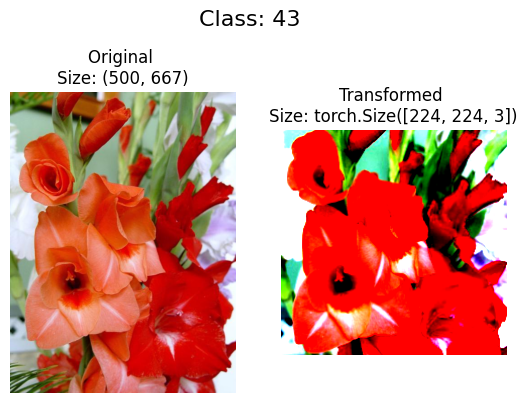

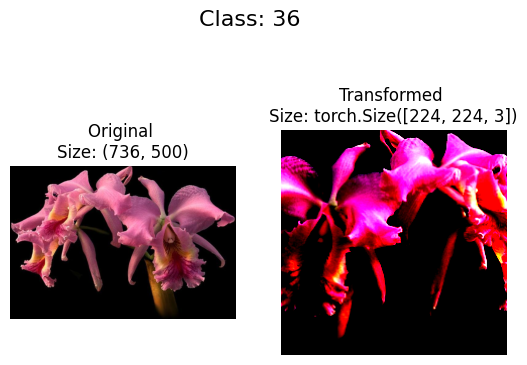

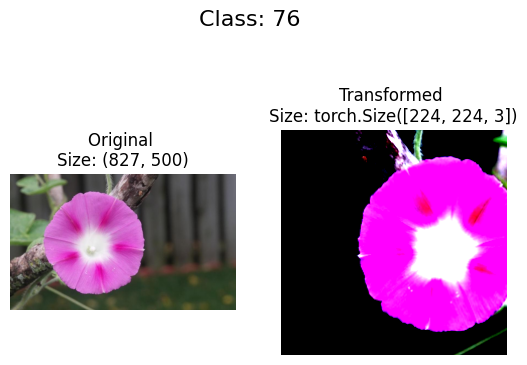

In [10]:
# Import the plot function
from utils import plot_transformed_images

# Plot the original vs transformed image
plot_transformed_images(train_images, train_labels, transform=train_transform, n=3)

## 8. Create Dataloaders

We create the `train_loader`, `val_loader`, `test_loader` with mini-batch size of 32.
* `train_loader` feeds batches of training data to the model during training.
* `val_loader` is used during training to monitor performance on unseen data and detect overfitting.
* `test_loader` is used after training to evaluate final model performance on a separate test set.
 
The reason of using `shuffle=True` for `train_loader` and `shuffle=False` (default) for `val_loader` and `test_loader`:
* Shuffling is used to break the sequential order of data, helping to improve model generalization and avoid overfitting to data patterns.
* Validation and testing datasets do not require shuffling since they are only used to evaluate the model's performance.

In [11]:
from torch.utils.data import DataLoader

# Define mini-batch size
batch_size = 32

# Create the DataLoader for the training dataset
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, # Load batch_size samples at a time
                          shuffle=True)    # Randomly shuffle the data at the start of each epoch to improve model generalization

# Create the DataLoader for the validatoin dataset
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # No shuffling needed for validation, as order doesn't affect model evaluation

# Create the DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size) 

## 9. Load Pretrained Model
We follow the following steps to load the pretrained model:
* Load the ResNet50 model with `pretrained_weights`
* Replace the final fully connected layer to output 102 classes
* Freeze the pretrained Layers except the final one

In [12]:
from torch import nn 

# Load the ResNet50 model with pretrained weights 
model = models.resnet50(weights=pretrained_weights)

# Replace the final fully connected layer to output 102 classes
num_classes = 102
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True

## 10. Move Model to Device

In [13]:
# Change the device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
# Move the model to the current device
model = model.to(device)

## 11. Define Loss and Optimizer

In [15]:
from torchmetrics import Accuracy

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
accuracy_fn = Accuracy(task='multiclass', num_classes=102).to(device)

## 12. Training Loop

In [16]:
from tqdm.auto import tqdm
from train import train_model, val_model

epochs = 10

print("Training ....")
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_model(model = model, 
                                        dataloader = train_loader, 
                                        optimizer = optimizer, 
                                        criterion = criterion, 
                                        acc_fn = accuracy_fn, 
                                        device = device)

    val_loss, val_acc = val_model(model = model,
                                  dataloader = val_loader, 
                                  optimizer = optimizer, 
                                  criterion = criterion, 
                                  acc_fn = accuracy_fn, 
                                  device = device)

    
    print(f'Epoch: {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} ')
    

Training ....


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0 | Train Loss: 4.3485 | Train Acc: 0.1304 | Val Loss: 3.7493 | Val Acc: 0.5841 
Epoch:   1 | Train Loss: 3.0538 | Train Acc: 0.8763 | Val Loss: 2.9791 | Val Acc: 0.7478 
Epoch:   2 | Train Loss: 2.1964 | Train Acc: 0.9616 | Val Loss: 2.4859 | Val Acc: 0.7977 
Epoch:   3 | Train Loss: 1.5554 | Train Acc: 0.9842 | Val Loss: 2.0826 | Val Acc: 0.8145 
Epoch:   4 | Train Loss: 1.1327 | Train Acc: 0.9961 | Val Loss: 1.8087 | Val Acc: 0.8251 
Epoch:   5 | Train Loss: 0.8350 | Train Acc: 0.9951 | Val Loss: 1.5719 | Val Acc: 0.8398 
Epoch:   6 | Train Loss: 0.6638 | Train Acc: 1.0000 | Val Loss: 1.4361 | Val Acc: 0.8477 
Epoch:   7 | Train Loss: 0.5085 | Train Acc: 1.0000 | Val Loss: 1.3352 | Val Acc: 0.8477 
Epoch:   8 | Train Loss: 0.4168 | Train Acc: 0.9990 | Val Loss: 1.2800 | Val Acc: 0.8486 
Epoch:   9 | Train Loss: 0.3341 | Train Acc: 1.0000 | Val Loss: 1.1501 | Val Acc: 0.8574 


## 13. Saving and loading model

In [17]:
# 1. Create models directory
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
model_name = '102-flowers-ResNet50.pth'
model_save_path = model_path/ model_name

# 3. Save model
print(f'Model saved to: {model_save_path}')
torch.save(obj = model.state_dict(), f = model_save_path)


Model saved to: models\102-flowers-ResNet50.pth


## 14. Loading the saved model and testing on it

In [18]:
# create an instance of the model to load it
loaded_model = models.resnet50(weights=None)

# Replace the final fully connected layer to output 102 classes
num_classes = 102
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, num_classes)

# Load model state dict 
loaded_model.load_state_dict(torch.load(f =  model_save_path))

# Moving lloaded_model to the current device
loaded_model.to(device)
print("Model Loaded")

Model Loaded


C:\Users\Dipesh\AppData\Local\Temp\ipykernel_17152\643417180.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f =  model_save_path

In [19]:
# Testing on loaded model
from train import eval_model

results = eval_model(model = loaded_model,
                     dataloader = test_loader, 
                     optimizer = optimizer, 
                     criterion = criterion, 
                     acc_fn = accuracy_fn, 
                     device = device)

print(results)

{'Loss': {1.1810117299847034}, 'Accuracy': {0.8416450777202072}}
